初期設定

In [1]:
using DifferentialEquations
#
sides = [:user, :cmpl]
#
TIMESTEP = 0.015625
TIMEMAX = 132
#
ComplementorsSwitchFlag=0
#
AdvertisingEndTimeA = 74
AdvertisingEndTimeB = 84
AdvertisingStartTimeA = 0
AdvertisingStartTimeB = 0
ComplementsAVelocity = Dict(:user => 0.2036, :cmpl => 0.2717)
ComplementsBVelocity = Dict(:user => 0.2112, :cmpl => 0.1546)
DepletionRateA = 0.1948
DepletionRateB = 0.01
IndirectNetworkEffectsStrengthA = 1.7042   # 感度分析のためにパラメータ設定する
IndirectNetworkEffectsStrengthB = 0.6587   # 感度分析のためにパラメータ設定する
InitialQualityA = 1
InitialQualityB = 1
ReferenceExpectationA = 23090.4
ReferenceExpectationB = 396977
ResponseTimeA = Dict(:user => 4.8356, :cmpl => 19.3069)
ResponseTimeB = Dict(:user => 48, :cmpl => 42.2854)
SalesVolumeAperUser = 1.7219
SalesVolumeBperUser = 2.9819
SubstituteValueA = Dict(:user => 1017.05, :cmpl => 1e+07)
SubstituteValueB = Dict(:user => 1e+07, :cmpl => 1)
#
TotalPopulation = Dict(:user => 5.36701e+07, :cmpl => 277)
#
AdvertisingEffectivenessA = Dict(:user => 0.0064, :cmpl => 0.0137)
AdvertisingEffectivenessB = Dict(:user => 0.0014, :cmpl => 0.009)
ContactRateA = Dict(:user => 1e-05, :cmpl => 1e-05)
ContactRateB = Dict(:user => 5, :cmpl => 0.0778)
ExitRateA = Dict(:user => 0.5, :cmpl => 0.1)
ExitRateB = Dict(:user => 0.0984, :cmpl => 0.001)
ReferenceComplementVolumeA = Dict(:user => 1.72525e+08, :cmpl => 1829)
ReferenceComplementVolumeB = Dict(:user => 7.8509e+07, :cmpl => 1454)

Dict{Symbol, Real} with 2 entries:
  :user => 7.8509e7
  :cmpl => 1454

モデルの定義

In [2]:

function systemdynamics!(dY, Y, p, t)

IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB = p
#
    # zidz function moved inside systemdynamics!

      function zidz(a, b)
          if abs(b) < 1e-6
              return 0.0
          else
              return a / b
          end
      end

 # Assign variables from Y
 AccumulatedAdoptersA = Dict(:user => Y[1], :cmpl => Y[2])
 AccumulatedAdoptersB = Dict(:user => Y[3], :cmpl => Y[4])
 ComplementsASalesVolume = Dict(:user => Y[5], :cmpl => Y[6])
 ComplementsBSalesVolume = Dict(:user => Y[7], :cmpl => Y[8])
 ExpectedQualityA = Y[9]
 ExpectedQualityB = Y[10]
 MultihomingUsers = Dict(:user => Y[11], :cmpl => Y[12])
 PlatformAAdopters = Dict(:user => Y[13], :cmpl => Y[14])
 PlatformBAdopters = Dict(:user => Y[15], :cmpl => Y[16])
 PlatformASalesVolume = Y[17]
 PlatformBSalesVolume = Y[18]
 PotentialAdopters = Dict(:user => Y[19], :cmpl => Y[20])

# Implement the equations
# Initialize dictionaries for variables that vary by side
sides = [:user, :cmpl]
flip(s) = s == :user ? :cmpl : :user

AdvertisingEffectsA = Dict(s => ifelse((t >= AdvertisingStartTimeA) && (t < AdvertisingEndTimeA), AdvertisingEffectivenessA[s]*PotentialAdopters[s], 0) for s in sides)
AdvertisingEffectsB = Dict(s => ifelse((t >= AdvertisingStartTimeB) && (t < AdvertisingEndTimeB), AdvertisingEffectivenessB[s]*PotentialAdopters[s], 0) for s in sides)

PlatformAAdopterFraction = Dict(s => PlatformAAdopters[s] / TotalPopulation[s] for s in sides)
PlatformBAdopterFraction = Dict(s => PlatformBAdopters[s] / TotalPopulation[s] for s in sides)

ComplementsASalesIncrement = Dict(s => PlatformAAdopters[s] * ComplementsAVelocity[s] for s in sides)
ComplementsBSalesIncrement = Dict(s => PlatformBAdopters[s] * ComplementsBVelocity[s] for s in sides)
ComplementValuetoPlatformA = Dict(s => ComplementsASalesVolume[s] / ReferenceComplementVolumeA[s] for s in sides)
ComplementValuetoPlatformB = Dict(s => ComplementsBSalesVolume[s] / ReferenceComplementVolumeB[s] for s in sides)

AdoptersExpectationA = PlatformAAdopters[:user] / ReferenceExpectationA
AdoptersExpectationB = PlatformBAdopters[:user] / ReferenceExpectationB
ExpectedIncrementA = AdoptersExpectationA
ExpectedIncrementB = AdoptersExpectationB
ExpectedQualityDepletionA = if t >= AdvertisingEndTimeA
    ExpectedQualityA * DepletionRateA
else
    0
end 
ExpectedQualityDepletionB = if t >= AdvertisingEndTimeB
    ExpectedQualityB * DepletionRateB
else
    0
end 

ValuetoNonPlatformAAdopters = Dict(s => ExpectedQualityA*ComplementValuetoPlatformA[flip(s)]*(PlatformAAdopterFraction[flip(s)])^IndirectNetworkEffectsStrengthA for s in sides)
ValuetoNonPlatformBAdopters = Dict(s => ExpectedQualityB*ComplementValuetoPlatformB[flip(s)]*(PlatformBAdopterFraction[flip(s)])^IndirectNetworkEffectsStrengthB for s in sides)

AdoptionFractionA = Dict(s => zidz(ValuetoNonPlatformAAdopters[s], ValuetoNonPlatformAAdopters[s] + ValuetoNonPlatformBAdopters[s] + SubstituteValueA[s]) for s in sides)
AdoptionFractionB = Dict(s => zidz(ValuetoNonPlatformBAdopters[s], ValuetoNonPlatformAAdopters[s] + ValuetoNonPlatformBAdopters[s] + SubstituteValueB[s]) for s in sides)

PlatformAValuetoPlatformAAdopters = Dict(s => ValuetoNonPlatformAAdopters[s] for s in sides)
PlatformAValuetoPlatformBAdopters = Dict(s => ValuetoNonPlatformAAdopters[s] for s in sides)
PlatformBValuetoPlatformAAdopters = Dict(s => ValuetoNonPlatformBAdopters[s] for s in sides)
PlatformBValuetoPlatformBAdopters = Dict(s => ValuetoNonPlatformBAdopters[s] for s in sides)

CombinedValuetoPlatformAAdopters = Dict(s => PlatformAValuetoPlatformAAdopters[s] + PlatformBValuetoPlatformAAdopters[s] for s in sides)
CombinedValuetoPlatformBAdopters = Dict(s => PlatformBValuetoPlatformBAdopters[s] + PlatformAValuetoPlatformBAdopters[s] for s in sides)

SwitchFractiontoA = Dict(s => zidz(PlatformAValuetoPlatformBAdopters[s], CombinedValuetoPlatformBAdopters[s] + SubstituteValueB[s]) for s in sides)
SwitchFractiontoB = Dict(s => zidz(PlatformBValuetoPlatformAAdopters[s], CombinedValuetoPlatformAAdopters[s] + SubstituteValueA[s]) for s in sides)
IndicatedSwitcherstoA = Dict(s => SwitchFractiontoA[s] * PlatformBAdopters[s] / ResponseTimeB[s] for s in sides)
IndicatedSwitcherstoB = Dict(s => SwitchFractiontoB[s] * PlatformAAdopters[s] / ResponseTimeA[s] for s in sides)

SwitchersfromAtoB = Dict(s => s==:user ? IndicatedSwitcherstoB[s] : IndicatedSwitcherstoB[s]*ComplementorsSwitchFlag for s in sides)
SwitchersfromBtoA = Dict(s => s==:user ? IndicatedSwitcherstoA[s] : IndicatedSwitcherstoA[s]*ComplementorsSwitchFlag for s in sides)
SwitcherstoA = SwitchersfromBtoA
SwitcherstoB = SwitchersfromAtoB

WordofMouthEffectsA = Dict(s => zidz(ContactRateA[s] * AdoptionFractionA[s] * PlatformAAdopters[s] * PotentialAdopters[s], TotalPopulation[s]) for s in sides)
WordofMouthEffectsB = Dict(s => zidz(ContactRateB[s] * AdoptionFractionB[s] * PlatformBAdopters[s] * PotentialAdopters[s], TotalPopulation[s]) for s in sides)

NewAdoptersA = Dict(s => min(PotentialAdopters[s]/TIMESTEP, AdvertisingEffectsA[s] + WordofMouthEffectsA[s]) for s in sides)
NewAdoptersB = Dict(s => min(PotentialAdopters[s]/TIMESTEP, AdvertisingEffectsB[s] + WordofMouthEffectsB[s]) for s in sides)

AdoptersAIncrement = Dict(s => NewAdoptersA[s] + SwitcherstoA[s] for s in sides)
AdoptersBIncrement = Dict(s => NewAdoptersB[s] + SwitcherstoB[s] for s in sides)

PlatformASalesIncrement = AdoptersAIncrement[:user]*SalesVolumeAperUser
PlatformBSalesIncrement = AdoptersBIncrement[:user]*SalesVolumeBperUser

PlatformAExit = Dict(s => ifelse(t >= AdvertisingEndTimeA, PlatformAAdopters[s]*ExitRateA[s], 0) for s in sides)
PlatformBExit = Dict(s => ifelse(t >= AdvertisingEndTimeB, PlatformBAdopters[s]*ExitRateB[s], 0) for s in sides)

MultihomingIncrement = Dict(s => SwitcherstoA[s] + SwitcherstoB[s] for s in sides)
MultihomingRatio = Dict(s => zidz(MultihomingUsers[s], (AccumulatedAdoptersA[s] + AccumulatedAdoptersB[s])) for s in sides)

TotalDiffusionRate = Dict(s => (PlatformAAdopters[s] + PlatformBAdopters[s]) / TotalPopulation[s] for s in sides)

#
# Update dY
#
dY[1] =  AdoptersAIncrement[:user]
dY[2] =  AdoptersAIncrement[:cmpl]
dY[3] =  AdoptersBIncrement[:user]
dY[4] =  AdoptersBIncrement[:cmpl]
dY[5] =  ComplementsASalesIncrement[:user]
dY[6] =  ComplementsASalesIncrement[:cmpl]
dY[7] =  ComplementsBSalesIncrement[:user]
dY[8] =  ComplementsBSalesIncrement[:cmpl]
dY[9] =  ExpectedIncrementA-ExpectedQualityDepletionA
dY[10] =  ExpectedIncrementB-ExpectedQualityDepletionB
dY[11] =  MultihomingIncrement[:user]
dY[12] =  MultihomingIncrement[:cmpl]
dY[13] = NewAdoptersA[:user]+SwitcherstoA[:user]-SwitcherstoB[:user]-PlatformAExit[:user]
dY[14] = NewAdoptersA[:cmpl]+SwitcherstoA[:cmpl]-SwitcherstoB[:cmpl]-PlatformAExit[:cmpl]
dY[15] = SwitcherstoB[:user]+NewAdoptersB[:user]-SwitcherstoA[:user]-PlatformBExit[:user]
dY[16] = SwitcherstoB[:cmpl]+NewAdoptersB[:cmpl]-SwitcherstoA[:cmpl]-PlatformBExit[:cmpl]
dY[17] =  PlatformASalesIncrement
dY[18] =  PlatformBSalesIncrement
dY[19] =  -NewAdoptersA[:user]-NewAdoptersB[:user]
dY[20] =  -NewAdoptersA[:cmpl]-NewAdoptersB[:cmpl]
#
end

systemdynamics! (generic function with 1 method)

時間積分のための初期値と時間範囲の設定
計算時間：0.01-3
50x50=26mins.

In [3]:
# Initial conditions
Y0 = [
    1.4956e06, 10,         # AccumulatedAdoptersA
    482252, 14,             # AccumulatedAdoptersB
    1.70593e06, 14,      # ComplementsASalesVolume
    803886, 18,             # ComplementsBSalesVolume
    InitialQualityA, InitialQualityB ,   # ExpectedQualityA, ExpectedQualityB
    0, 0,                         # MultihomingUsers
    1.4956e06, 10,        # PlatformAAdopters
    482252, 14,             # PlatformBAdopters
   1.4956e06, 482252, # PlatformASalesVolume, PlatformBSalesVolume
   5.16922e7,  253        # PotentialAdopters
]

# Time span
tspan = (0.0, TIMEMAX)

# Solve the ODE problem for different values of Indirect Network Effects Strength
IndirectNetworkEffectsStrengthA_values = range(0.01, stop=3.0, length=50)
IndirectNetworkEffectsStrengthB_values = range(0.01, stop=3.0, length=50)
#IndirectNetworkEffectsStrengthA_values = range(0.01, stop=2.0, length=40)
#IndirectNetworkEffectsStrengthB_values = range(0.01, stop=2.0, length=40)
#IndirectNetworkEffectsStrengthA_values = range(0.2, stop=2.0, length=20)
#IndirectNetworkEffectsStrengthB_values = range(0.2, stop=2.0, length=20)

# zidz function 
function zidz(a, b)
    if abs(b) < 1e-6
        return 0.0
    else
        return a / b
    end
end

results = []

for IndirectNetworkEffectsStrengthA in IndirectNetworkEffectsStrengthA_values
    for IndirectNetworkEffectsStrengthB in IndirectNetworkEffectsStrengthB_values
        #
        params = [IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB]
        prob = ODEProblem(systemdynamics!, Y0, tspan, params)
        sol = solve(prob, Euler(), dt=TIMESTEP) 
        #sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

         # Extract the values of AccumulatedAdoptersA, B at t = TIMEMAX
        aAdoptersA_user_TMAX = sol.u[end][1]
        aAdoptersA_cmpl_TMAX = sol.u[end][2]
        aAdoptersB_user_TMAX = sol.u[end][3]
        aAdoptersB_cmpl_TMAX = sol.u[end][4]

        # Extract the values of MultihomingRatio for users and complementors at t = TIMEMAX
        mhg_user_TMAX = sol.u[end][11]
        mhg_cmpl_TMAX = sol.u[end][12]
        mhg_ratios_user_TMAX = zidz(sol.u[end][11], (sol.u[end][1] + sol.u[end][3])) 
        mhg_ratios_cmpl_TMAX = zidz(sol.u[end][12], (sol.u[end][2] + sol.u[end][4])) 

       # Print the results
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, mhg_ratios_user_TMAX: $mhg_ratios_user_TMAX, mhg_ratios_cmpl_TMAX: $mhg_ratios_cmpl_TMAX")
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, aAdoptersA_user_TMAX : $aAdoptersA_user_TMAX, aAdoptersA_cmpl_TMAX : $aAdoptersA_cmpl_TMAX")
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, aAdoptersB_user_TMAX : $aAdoptersB_user_TMAX, aAdoptersB_cmpl_TMAX : $aAdoptersB_cmpl_TMAX")


        # Store the results
        push!(results, (IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB, 
        aAdoptersA_user_TMAX, aAdoptersA_cmpl_TMAX, aAdoptersB_user_TMAX, aAdoptersB_cmpl_TMAX,
        mhg_user_TMAX, mhg_cmpl_TMAX,
        mhg_ratios_user_TMAX, mhg_ratios_cmpl_TMAX))
    end
end


次のパッケージを事前にインストールすることが必要となる。JuliaのREPLを用いる（その方が早い）
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")

mhg_ratios_user_TMAX の最大値と最小値と、その値に対応するIndirectNetworkEffectsStrengthA、IndirectNetworkEffectsStrengthBの値を画面に表示し、外部ファイルにも記録する．

In [4]:
using CSV, DataFrames

# In addition to the previous code block

# Initialize min, max values and their corresponding parameters
min_mhg_ratios_user_TMAX = Inf
max_mhg_ratios_user_TMAX = -Inf
min_params = (0.0, 0.0)
max_params = (0.0, 0.0)

# Process results and find min/max values
for res in results
    if res[9] < min_mhg_ratios_user_TMAX
        min_mhg_ratios_user_TMAX = res[9]
        min_params = (res[1], res[2])
    end
    if res[9] > max_mhg_ratios_user_TMAX
        max_mhg_ratios_user_TMAX = res[9]
        max_params = (res[1], res[2])
    end
end

# Print min/max values and corresponding parameters
println("Min mhg_ratios_user_TMAX: $min_mhg_ratios_user_TMAX, 
         IndirectNetworkEffectsStrengthA: $(min_params[1]), 
         IndirectNetworkEffectsStrengthB: $(min_params[2])")
println("Max mhg_ratios_user_TMAX: $max_mhg_ratios_user_TMAX, 
         IndirectNetworkEffectsStrengthA: $(max_params[1]), 
         IndirectNetworkEffectsStrengthB: $(max_params[2])")

# Convert results to DataFrame
df = DataFrame(IndirectNetworkEffectsStrengthA = [res[1] for res in results], 
               IndirectNetworkEffectsStrengthB = [res[2] for res in results], 
               aAdoptersA_user_TMAX = [res[3] for res in results], 
               aAdoptersA_cmpl_TMAX = [res[4] for res in results], 
               aAdoptersB_user_TMAX = [res[5] for res in results], 
               aAdoptersB_cmpl_TMAX = [res[6] for res in results], 
               mhg_user_TMAX = [res[7] for res in results], 
               mhg_cmpl_TMAX = [res[8] for res in results], 
               mhg_ratios_user_TMAX = [res[9] for res in results], 
               mhg_ratios_cmpl_TMAX = [res[10] for res in results])

# Write results to CSV file
CSV.write("resultsDSPSP03.csv", df)

# Write min/max values and their parameters to CSV file
min_max_df = DataFrame(min_mhg_ratios_user_TMAX = [min_mhg_ratios_user_TMAX], 
                       IndirectNetworkEffectsStrengthA_min = [min_params[1]], 
                       IndirectNetworkEffectsStrengthB_min = [min_params[2]], 
                       max_mhg_ratios_user_TMAX = [max_mhg_ratios_user_TMAX], 
                       IndirectNetworkEffectsStrengthA_max = [max_params[1]], 
                       IndirectNetworkEffectsStrengthB_max = [max_params[2]])
CSV.write("min_max_resultsDSPSP03.csv", min_max_df)



Min mhg_ratios_user_TMAX: 0.0016250267344519642, 
         IndirectNetworkEffectsStrengthA: 0.01, 
         IndirectNetworkEffectsStrengthB: 3.0
Max mhg_ratios_user_TMAX: 0.31915477129784114, 
         IndirectNetworkEffectsStrengthA: 3.0, 
         IndirectNetworkEffectsStrengthB: 0.01


"min_max_resultsDSPSP03.csv"

線形回帰、交互作用回帰、指数回帰と累乗回帰による推定式の評価も追加する。4モデルを用いて推定結果を比較する

In [5]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase

# Read the results
df = CSV.read("resultsDSPSP03.csv", DataFrame)

# Log transformation
df.mhg_ratios_user_TMAX_log = log.(df.mhg_ratios_user_TMAX)

# Define a linear model
linear_model = lm(@formula(mhg_ratios_user_TMAX ~ IndirectNetworkEffectsStrengthA + IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the linear model
println("Linear Model Equation: mhg_ratios_user_TMAX = ", coef(linear_model)[1], " + ", coef(linear_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(linear_model)[3], " * IndirectNetworkEffectsStrengthB")

# Define a model with interaction terms
interaction_model = lm(@formula(mhg_ratios_user_TMAX ~ IndirectNetworkEffectsStrengthA*IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the interaction model
println("Interaction Model Equation: mhg_ratios_user_TMAX = ", coef(interaction_model)[1], " + ", coef(interaction_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(interaction_model)[3], " * IndirectNetworkEffectsStrengthB + ", coef(interaction_model)[4], " * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB")

# Define an exponential regression model (requires log transformation)
exp_model = lm(@formula(mhg_ratios_user_TMAX_log ~ IndirectNetworkEffectsStrengthA + IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the exponential model
println("Exponential Model Equation: log(mhg_ratios_user_TMAX) = ", coef(exp_model)[1], " + ", coef(exp_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(exp_model)[3], " * IndirectNetworkEffectsStrengthB")

# Define a power regression model (requires log transformation)
power_model = lm(@formula(mhg_ratios_user_TMAX_log ~ log(IndirectNetworkEffectsStrengthA) + log(IndirectNetworkEffectsStrengthB)), df)

# Print the coefficients and formula of the power model
println("Power Model Equation: log(mhg_ratios_user_TMAX) = ", coef(power_model)[1], " + ", coef(power_model)[2], " * log(IndirectNetworkEffectsStrengthA) + ", coef(power_model)[3], " * log(IndirectNetworkEffectsStrengthB)")

# Predicted values
df.prediction_linear = GLM.predict(linear_model, df)
df.prediction_interaction = GLM.predict(interaction_model, df)
df.prediction_exp = exp.(GLM.predict(exp_model, df))
df.prediction_power = exp.(GLM.predict(power_model, df))

# Compute AIC for each model
aic_linear = aic(linear_model)
aic_interaction = aic(interaction_model)
aic_exp = aic(exp_model)
aic_power = aic(power_model)

# Compute Mean Squared Error
MSE_linear = mean((df.mhg_ratios_user_TMAX .- df.prediction_linear).^2)
MSE_interaction = mean((df.mhg_ratios_user_TMAX .- df.prediction_interaction).^2)
MSE_exp = mean((df.mhg_ratios_user_TMAX .- df.prediction_exp).^2)
MSE_power = mean((df.mhg_ratios_user_TMAX .- df.prediction_power).^2)

# Compute R-squared
TSS = sum((df.mhg_ratios_user_TMAX .- mean(df.mhg_ratios_user_TMAX)).^2)
SSE_linear = sum((df.mhg_ratios_user_TMAX .- df.prediction_linear).^2)
SSE_interaction = sum((df.mhg_ratios_user_TMAX .- df.prediction_interaction).^2)
SSE_exp = sum((df.mhg_ratios_user_TMAX .- df.prediction_exp).^2)
SSE_power = sum((df.mhg_ratios_user_TMAX .- df.prediction_power).^2)
R2_linear = 1 - SSE_linear / TSS
R2_interaction = 1 - SSE_interaction / TSS
R2_exp = 1 - SSE_exp / TSS
R2_power = 1 - SSE_power / TSS

# Display the results in tabular form
println("Linear Model:")
println(coeftable(linear_model))
println("AIC: ", aic_linear)
println("MSE: ", MSE_linear)
println("R-squared: ", R2_linear)
println("---------------")
println("Interaction Model:")
println(coeftable(interaction_model))
println("AIC: ", aic_interaction)
println("MSE: ", MSE_interaction)
println("R-squared: ", R2_interaction)
println("---------------")
println("Exponential Model:")
println(coeftable(exp_model))
println("AIC: ", aic_exp)
println("MSE: ", MSE_exp)
println("R-squared: ", R2_exp)
println("---------------")
println("Power Model:")
println(coeftable(power_model))
println("AIC: ", aic_power)
println("MSE: ", MSE_power)
println("R-squared: ", R2_power)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Linear", "Interaction", "Exponential", "Power"],
    AIC = [aic_linear, aic_interaction, aic_exp, aic_power],
    MSE = [MSE_linear, MSE_interaction, MSE_exp, MSE_power],
    R2 = [R2_linear, R2_interaction, R2_exp, R2_power]
)

# Sort the DataFrame by AIC
sort!(model_evaluation, :AIC)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# Font size for various parts of the plot
fontsize = 10

# 3D plot of original data points and regression lines
#p = plot(df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.mhg_ratios_user_TMAX, st=:scatter, title="Data and Fitted Regression Lines", xlabel="IndirectNetworkEffectsStrengthA", ylabel="IndirectNetworkEffectsStrengthB", zlabel="mhg_ratios_user_TMAX", legend=false, guidefontsize=fontsize, tickfontsize=fontsize, titlefontsize=fontsize, color=:blue, camera=(45, 45), size=(800, 600), xlims=(0, 3), ylims=(0, 3), zlims=(0, 1.0))

# add regression lines
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_linear, st=:surface, legend=false, color=:reds, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_interaction, st=:surface, legend=false, color=:greens, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_exp, st=:surface, legend=false, color=:purple, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_power, st=:surface, legend=false, color=:yellow, alpha=0.5)

#display(p)

# 画像ファイルとして保存
#savefig(p, "estimate_MHGratio_DSPSP.png") 

#savefig(p, "estimate_MHGratio_DSPSP.pdf") 

#savefig(p, "estimate_MHGratio_DSPSP.svg") 

# CSV形式でmodel_evaluationを保存
CSV.write("estimate_MHGratio_DSPSP.csv", model_evaluation)

Linear Model Equation: mhg_ratios_user_TMAX = 0.06911046618416122 + 0.025109256222840968 * IndirectNetworkEffectsStrengthA + -0.042760782665876046 * IndirectNetworkEffectsStrengthB
Interaction Model Equation: mhg_ratios_user_TMAX = 0.01074284992775757 + 0.06389172549619886 * IndirectNetworkEffectsStrengthA + -0.003978313392518103 * IndirectNetworkEffectsStrengthB + -0.025769082573659736 * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB
Exponential Model Equation: log(mhg_ratios_user_TMAX) = -2.9801090285181324 + 0.6263208294013684 * IndirectNetworkEffectsStrengthA + -1.1756018615522534 * IndirectNetworkEffectsStrengthB
Power Model Equation: log(mhg_ratios_user_TMAX) = -3.7791859783406103 + 0.44195988895495153 * log(IndirectNetworkEffectsStrengthA) + -0.8205829516451463 * log(IndirectNetworkEffectsStrengthB)
Linear Model:
──────────────────────────────────────────────────────────────────────────────────────────────────
                                      Coef.   Std.

"estimate_MHGratio_DSPSP.csv"

mhg_ratios_user_TMAXが0.04 以上のデータのみを用いて4つの異なるモデル（線形、交互作用、指数、パワー）を訓練し、それぞれのモデルの評価指標（AIC、MSE、R2）を算出し、表形式で表示する。また、3Dプロットを作成し、元のデータポイントと各モデルによる回帰線を表示する。

In [6]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase

# Read the results
df = CSV.read("resultsDSPSP03.csv", DataFrame)

# Filter data where mhg_ratios_user_TMAX is greater than 0.04
df = df[df.mhg_ratios_user_TMAX .>= 0.04, :]

# Log transformation
df.mhg_ratios_user_TMAX_log = log.(df.mhg_ratios_user_TMAX)

# Define a linear model
linear_model = lm(@formula(mhg_ratios_user_TMAX ~ IndirectNetworkEffectsStrengthA + IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the linear model
println("Linear Model Equation: mhg_ratios_user_TMAX = ", coef(linear_model)[1], " + ", coef(linear_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(linear_model)[3], " * IndirectNetworkEffectsStrengthB")

# Define a model with interaction terms
interaction_model = lm(@formula(mhg_ratios_user_TMAX ~ IndirectNetworkEffectsStrengthA*IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the interaction model
println("Interaction Model Equation: mhg_ratios_user_TMAX = ", coef(interaction_model)[1], " + ", coef(interaction_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(interaction_model)[3], " * IndirectNetworkEffectsStrengthB + ", coef(interaction_model)[4], " * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB")

# Define an exponential regression model (requires log transformation)
exp_model = lm(@formula(mhg_ratios_user_TMAX_log ~ IndirectNetworkEffectsStrengthA + IndirectNetworkEffectsStrengthB), df)

# Print the coefficients and formula of the exponential model
println("Exponential Model Equation: log(mhg_ratios_user_TMAX) = ", coef(exp_model)[1], " + ", coef(exp_model)[2], " * IndirectNetworkEffectsStrengthA + ", coef(exp_model)[3], " * IndirectNetworkEffectsStrengthB")

# Define a power regression model (requires log transformation)
power_model = lm(@formula(mhg_ratios_user_TMAX_log ~ log(IndirectNetworkEffectsStrengthA) + log(IndirectNetworkEffectsStrengthB)), df)

# Print the coefficients and formula of the power model
println("Power Model Equation: log(mhg_ratios_user_TMAX) = ", coef(power_model)[1], " + ", coef(power_model)[2], " * log(IndirectNetworkEffectsStrengthA) + ", coef(power_model)[3], " * log(IndirectNetworkEffectsStrengthB)")

# Predicted values
df.prediction_linear = GLM.predict(linear_model, df)
df.prediction_interaction = GLM.predict(interaction_model, df)
df.prediction_exp = exp.(GLM.predict(exp_model, df))
df.prediction_power = exp.(GLM.predict(power_model, df))

# Compute AIC for each model
aic_linear = aic(linear_model)
aic_interaction = aic(interaction_model)
aic_exp = aic(exp_model)
aic_power = aic(power_model)

# Compute Mean Squared Error
MSE_linear = mean((df.mhg_ratios_user_TMAX .- df.prediction_linear).^2)
MSE_interaction = mean((df.mhg_ratios_user_TMAX .- df.prediction_interaction).^2)
MSE_exp = mean((df.mhg_ratios_user_TMAX .- df.prediction_exp).^2)
MSE_power = mean((df.mhg_ratios_user_TMAX .- df.prediction_power).^2)

# Compute R-squared
TSS = sum((df.mhg_ratios_user_TMAX .- mean(df.mhg_ratios_user_TMAX)).^2)
SSE_linear = sum((df.mhg_ratios_user_TMAX .- df.prediction_linear).^2)
SSE_interaction = sum((df.mhg_ratios_user_TMAX .- df.prediction_interaction).^2)
SSE_exp = sum((df.mhg_ratios_user_TMAX .- df.prediction_exp).^2)
SSE_power = sum((df.mhg_ratios_user_TMAX .- df.prediction_power).^2)
R2_linear = 1 - SSE_linear / TSS
R2_interaction = 1 - SSE_interaction / TSS
R2_exp = 1 - SSE_exp / TSS
R2_power = 1 - SSE_power / TSS

# Display the results in tabular form
println("Linear Model:")
println(coeftable(linear_model))
println("AIC: ", aic_linear)
println("MSE: ", MSE_linear)
println("R-squared: ", R2_linear)
println("---------------")
println("Interaction Model:")
println(coeftable(interaction_model))
println("AIC: ", aic_interaction)
println("MSE: ", MSE_interaction)
println("R-squared: ", R2_interaction)
println("---------------")
println("Exponential Model:")
println(coeftable(exp_model))
println("AIC: ", aic_exp)
println("MSE: ", MSE_exp)
println("R-squared: ", R2_exp)
println("---------------")
println("Power Model:")
println(coeftable(power_model))
println("AIC: ", aic_power)
println("MSE: ", MSE_power)
println("R-squared: ", R2_power)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Linear", "Interaction", "Exponential", "Power"],
    AIC = [aic_linear, aic_interaction, aic_exp, aic_power],
    MSE = [MSE_linear, MSE_interaction, MSE_exp, MSE_power],
    R2 = [R2_linear, R2_interaction, R2_exp, R2_power]
)

# Sort the DataFrame by AIC
sort!(model_evaluation, :AIC)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# Font size for various parts of the plot
fontsize = 10

# 3D plot of original data points and regression lines
#p = plot(df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.mhg_ratios_user_TMAX, st=:scatter, title="Data and Fitted Regression Lines", xlabel="IndirectNetworkEffectsStrengthA", ylabel="IndirectNetworkEffectsStrengthB", zlabel="mhg_ratios_user_TMAX", legend=false, guidefontsize=fontsize, tickfontsize=fontsize, titlefontsize=fontsize, color=:blue, camera=(45, 45), size=(800, 600), xlims=(0, 3), ylims=(0, 3), zlims=(0, 1.0))

# add regression lines
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_linear, st=:surface, legend=false, color=:reds, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_interaction, st=:surface, legend=false, color=:greens, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_exp, st=:surface, legend=false, color=:purple, alpha=0.5)
#plot!(p, df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB, df.prediction_power, st=:surface, legend=false, color=:yellow, alpha=0.5)

#display(p)

# 画像ファイルとして保存
#savefig(p, "estimate004_MHGratio_DSPSP.png") 

#savefig(p, "estimate004_MHGratio_DSPSP.pdf") 

#savefig(p, "estimate004_MHGratio_DSPSP.svg") 

# CSV形式でmodel_evaluationを保存
CSV.write("estimate004_MHGratio_DSPSP.csv", model_evaluation)

Linear Model Equation: mhg_ratios_user_TMAX = 0.04648584746806753 + 0.06953797618787984 * IndirectNetworkEffectsStrengthA + -0.13715691329978902 * IndirectNetworkEffectsStrengthB
Interaction Model Equation: mhg_ratios_user_TMAX = 0.02710812262066364 + 0.07869390542490137 * IndirectNetworkEffectsStrengthA + -0.08210085374384526 * IndirectNetworkEffectsStrengthB + -0.023943277597914595 * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB
Exponential Model Equation: log(mhg_ratios_user_TMAX) = -2.9316789829205363 + 0.6349418969377126 * IndirectNetworkEffectsStrengthA + -1.2722405497358151 * IndirectNetworkEffectsStrengthB
Power Model Equation: log(mhg_ratios_user_TMAX) = -3.071799773998735 + 0.5542672497317797 * log(IndirectNetworkEffectsStrengthA) + -0.3305384003024905 * log(IndirectNetworkEffectsStrengthB)
Linear Model:
──────────────────────────────────────────────────────────────────────────────────────────────────
                                      Coef.   Std. Erro

"estimate004_MHGratio_DSPSP.csv"

非線形回帰（非線形最小二乗法）のために初期値を変更する。

In [7]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase, LsqFit

# Read the results
df = CSV.read("resultsDSPSP03.csv", DataFrame)

println(size(df.IndirectNetworkEffectsStrengthA))
println(size(df.IndirectNetworkEffectsStrengthB))
println(size(df.mhg_ratios_user_TMAX))

# Model including interaction term
function model(x, p)
  p[1] .+ p[2].*x[:,1] .+ p[3].*x[:,2] .+ p[4].*x[:,1].^2 .+ p[5].*x[:,2].^2 .+ p[6].*x[:,1].*x[:,2]
end

# Initial guess
p0 = [0.2, 0.03, 0.28, -0.05, -0.06, 0.01] # Add an initial guess for the new parameter

# Make sure xdata is a 2-dimensional array by transposing it
ydata = df.mhg_ratios_user_TMAX
xdata = hcat(df.IndirectNetworkEffectsStrengthA, df.IndirectNetworkEffectsStrengthB)

fit = curve_fit(model, xdata, ydata, p0)

# 非線形モデルの係数
coefs = coef(fit)

# Print the coefficients and formula of the nonlinear model
println("Nonlinear Model Equation: mhg_ratios_user_TMAX = ", coefs[1], " + ", coefs[2], " * IndirectNetworkEffectsStrengthA + ", coefs[3], " * IndirectNetworkEffectsStrengthB + ", coefs[4], " * IndirectNetworkEffectsStrengthA^2 + ", coefs[5], " * IndirectNetworkEffectsStrengthB^2 + ", coefs[6], " * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB")

# Predicted values
df.prediction_nonlinear = model(xdata, coefs)

# Compute residual sum of squares for the nonlinear model
SSE_nonlinear = sum((df.mhg_ratios_user_TMAX .- df.prediction_nonlinear).^2)

# Compute AIC for the nonlinear model
n = length(df.mhg_ratios_user_TMAX)
k = length(coefs)
#aic_nonlinear = 2*k - 2*log(SSE_nonlinear/n)
aic_nonlinear = 2*k + 2*log(SSE_nonlinear/n)

# Compute Mean Squared Error for the nonlinear model
MSE_nonlinear = SSE_nonlinear / n

# Compute R-squared for the nonlinear model
TSS = sum((df.mhg_ratios_user_TMAX .- mean(df.mhg_ratios_user_TMAX)).^2)
R2_nonlinear = 1 - SSE_nonlinear / TSS

# Display the results in tabular form for the nonlinear model
println("Nonlinear Model:")
println("Coefficients: ", coefs)
println("AIC: ", aic_nonlinear)
println("MSE: ", MSE_nonlinear)
println("R-squared: ", R2_nonlinear)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Nonlinear"],
    AIC = [aic_nonlinear],
    MSE = [MSE_nonlinear],
    Rsquared = [R2_nonlinear]
)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# CSV形式でmodel_evaluationを保存
CSV.write("estimateNonl_MHGratio_DSPSP.csv", model_evaluation)


(2500,)
(2500,)
(2500,)
Nonlinear Model Equation: mhg_ratios_user_TMAX = 0.056763800789323096 + 0.046028816415197606 * IndirectNetworkEffectsStrengthA + -0.07910835743126089 * IndirectNetworkEffectsStrengthB + 0.005934521289370255 * IndirectNetworkEffectsStrengthA^2 + 0.02496014752117811 * IndirectNetworkEffectsStrengthB^2 + -0.02576908257366168 * IndirectNetworkEffectsStrengthA * IndirectNetworkEffectsStrengthB
Nonlinear Model:
Coefficients: [0.056763800789323096, 0.046028816415197606, -0.07910835743126089, 0.005934521289370255, 0.02496014752117811, -0.02576908257366168]
AIC: -5.506988754142373
MSE: 0.00015790856782825388
R-squared: 0.9432011577171004
Model Evaluation:
1×4 DataFrame
 Row │ Model      AIC       MSE          Rsquared 
     │ String     Float64   Float64      Float64  
─────┼────────────────────────────────────────────
   1 │ Nonlinear  -5.50699  0.000157909  0.943201


"estimateNonl_MHGratio_DSPSP.csv"

時間積分結果をCSV形式で外部ファイルに出力し、その結果を読み込み後に等高線図を描画する。
出力ファイル名を"contourdspsp.csv"とする。描画にはPlotsパッケージを使用する。
等高線図用行列に変換する．等高線図を出力する．

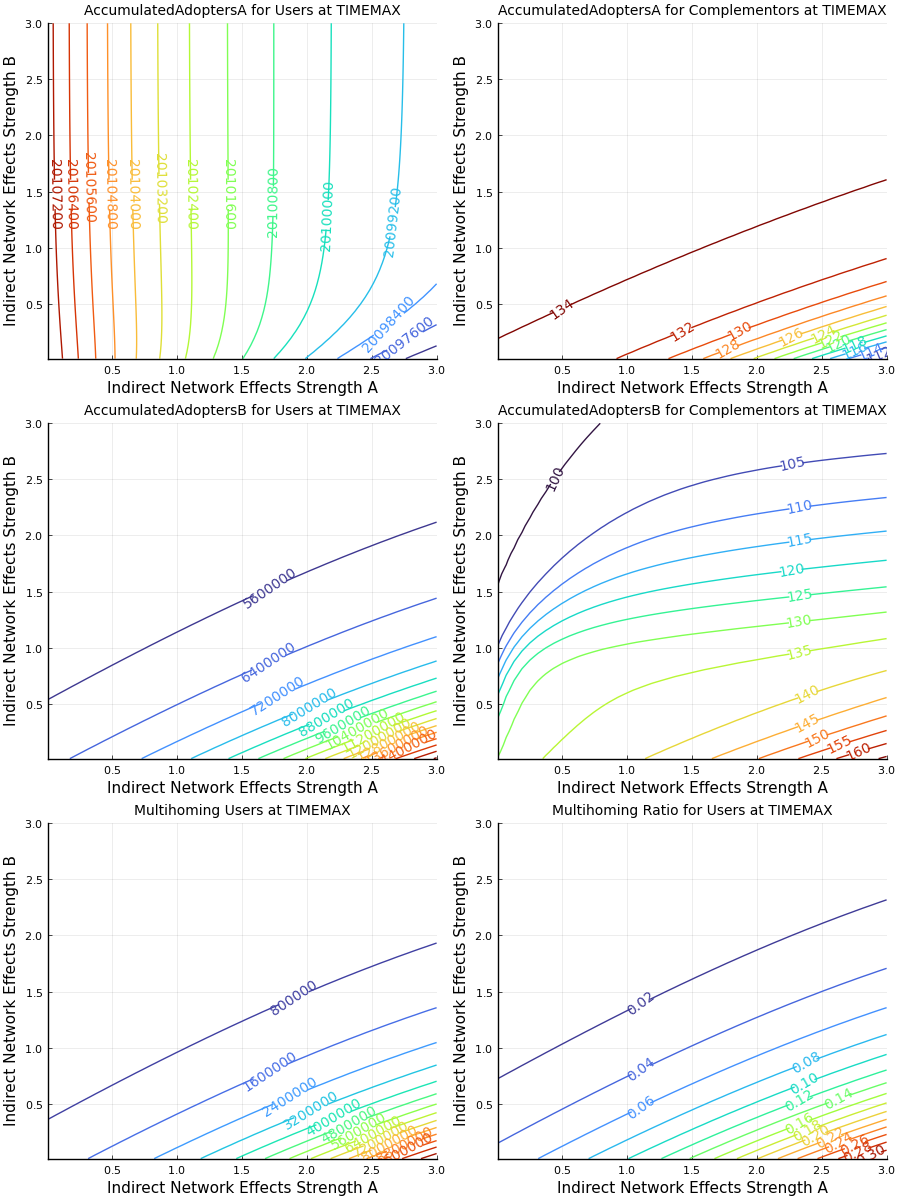

In [13]:
using CSV, DataFrames
using Plots; pythonplot()
using LaTeXStrings

#println(length(data[:, :IndirectNetworkEffectsStrengthA]))
#println(length(IndirectNetworkEffectsStrengthA_values) * length(IndirectNetworkEffectsStrengthB_values))
#println(length(results))
# 
using CSV, DataFrames, Plots

# Save the results to a CSV file
df = DataFrame(
    IndirectNetworkEffectsStrengthA = [r[1] for r in results],
    IndirectNetworkEffectsStrengthB = [r[2] for r in results],
    aAdoptersA_user_TMAX = [r[3] for r in results],
    aAdoptersA_cmpl_TMAX = [r[4] for r in results],
    aAdoptersB_user_TMAX = [r[5] for r in results],
    aAdoptersB_cmpl_TMAX = [r[6] for r in results],
    mhg_user_TMAX = [r[7] for r in results],
    mhg_cmpl_TMAX = [r[8] for r in results],
    mhg_ratios_user_TMAX = [r[9] for r in results],
    mhg_ratios_cmpl_TMAX = [r[10] for r in results]
)
CSV.write("contourdspsp.csv", df)

# Read the results from the CSV file
data = CSV.read("contourdspsp.csv", DataFrame)

# Define the values for the contour plot
xvals = data[:, :IndirectNetworkEffectsStrengthA]
yvals = data[:, :IndirectNetworkEffectsStrengthB]
zvals1 = data[:, :aAdoptersA_user_TMAX]
zvals2 = data[:, :aAdoptersA_cmpl_TMAX]
zvals3 = data[:, :aAdoptersB_user_TMAX]
zvals4 = data[:, :aAdoptersB_cmpl_TMAX]
zvals5 = data[:, :mhg_user_TMAX]
zvals6 = data[:, :mhg_cmpl_TMAX]
zvals7 = data[:, :mhg_ratios_user_TMAX]
zvals8 = data[:, :mhg_ratios_cmpl_TMAX]

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
yvals_mtrx = reshape(yvals, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals1_mtrx = reshape(zvals1, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals2_mtrx = reshape(zvals2, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals3_mtrx = reshape(zvals3, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals4_mtrx = reshape(zvals4, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals5_mtrx = reshape(zvals5, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals6_mtrx = reshape(zvals6, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals7_mtrx = reshape(zvals7, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals8_mtrx = reshape(zvals8, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))

# Create the contour plots

p1 = contour(xvals_mtrx, yvals_mtrx, zvals1_mtrx, title="AccumulatedAdoptersA for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p2 = contour(xvals_mtrx, yvals_mtrx, zvals2_mtrx, title="AccumulatedAdoptersA for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p3 = contour(xvals_mtrx, yvals_mtrx, zvals3_mtrx, title="AccumulatedAdoptersB for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p4 = contour(xvals_mtrx, yvals_mtrx, zvals4_mtrx, title="AccumulatedAdoptersB for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p5 = contour(xvals_mtrx, yvals_mtrx, zvals5_mtrx, title="Multihoming Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p6 = contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)

# Display the plot with larger size
display(plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200)))

総天然色等高線図を出力する

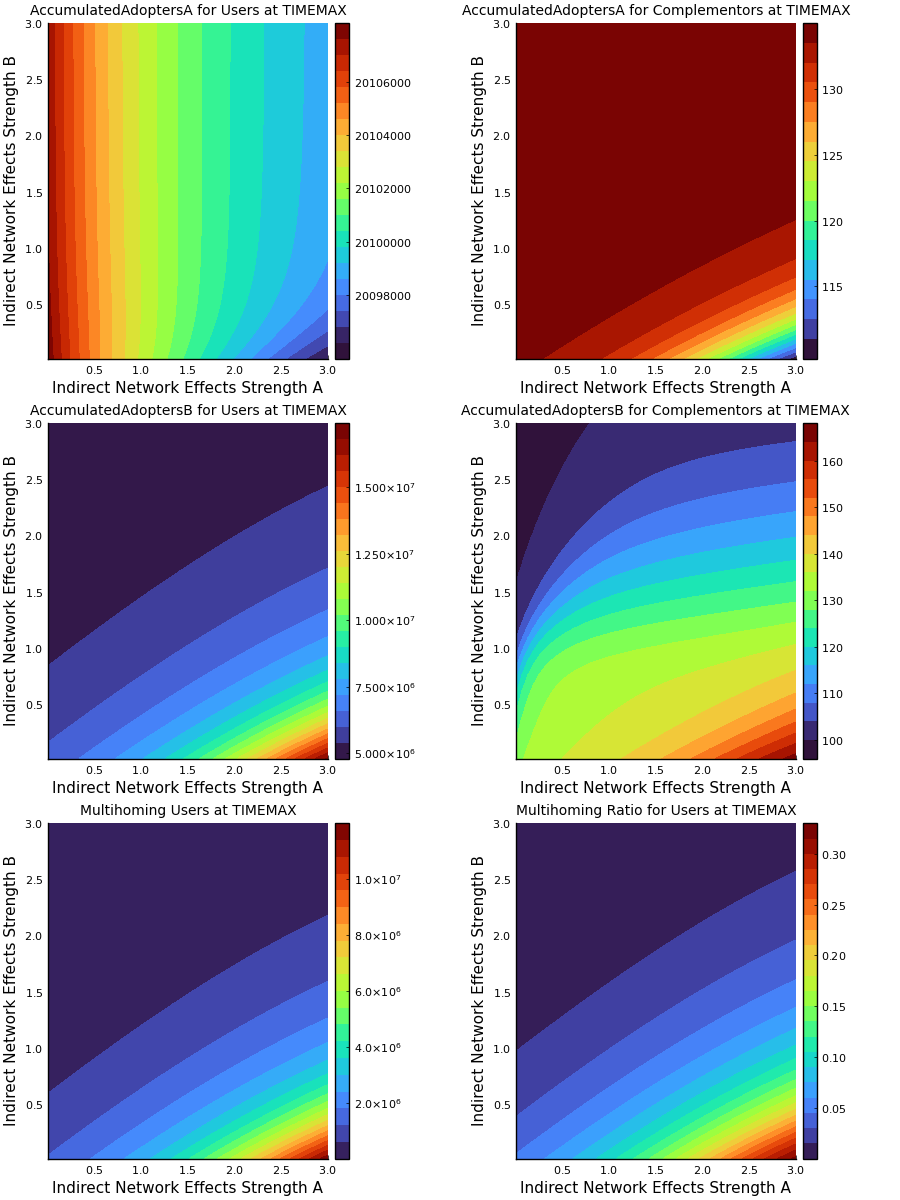

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [14]:
using Plots
plot()

# Create the contour plots
p1 = contourf(xvals_mtrx, yvals_mtrx, zvals1_mtrx, title="AccumulatedAdoptersA for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)
p2 = contourf(xvals_mtrx, yvals_mtrx, zvals2_mtrx, title="AccumulatedAdoptersA for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)
p3 = contourf(xvals_mtrx, yvals_mtrx, zvals3_mtrx, title="AccumulatedAdoptersB for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)
p4 = contourf(xvals_mtrx, yvals_mtrx, zvals4_mtrx, title="AccumulatedAdoptersB for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)
p5 = contourf(xvals_mtrx, yvals_mtrx, zvals5_mtrx, title="Multihoming Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)
p6 = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)

# Display the plot with larger size
display(plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200)))

総天然色等高線図をファイル出力する

In [15]:
using Plots
plot()

# Create the combined plot
p = plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200))

# Save the contour plot to a PNG file
savefig(p, "fullcontourdspsp.png")

# Save the contour plot to a PDF file
savefig(p, "fullcontourdspsp.pdf")

# Save the contour plot to a EPS file
savefig(p, "fullcontourdspsp.eps")

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


"d:\\Dropbox\\JuliaDocs\\1_DS_PSP_Case\\fullcontourdspsp.eps"

シミュレーションから得られたマルチホーミング率の等高線図と交差項回帰の推定式から得られる等高線図を出力する．(1)
推定されたマルチホーミング率が負の値の場合に、強制的に0値を設定する．

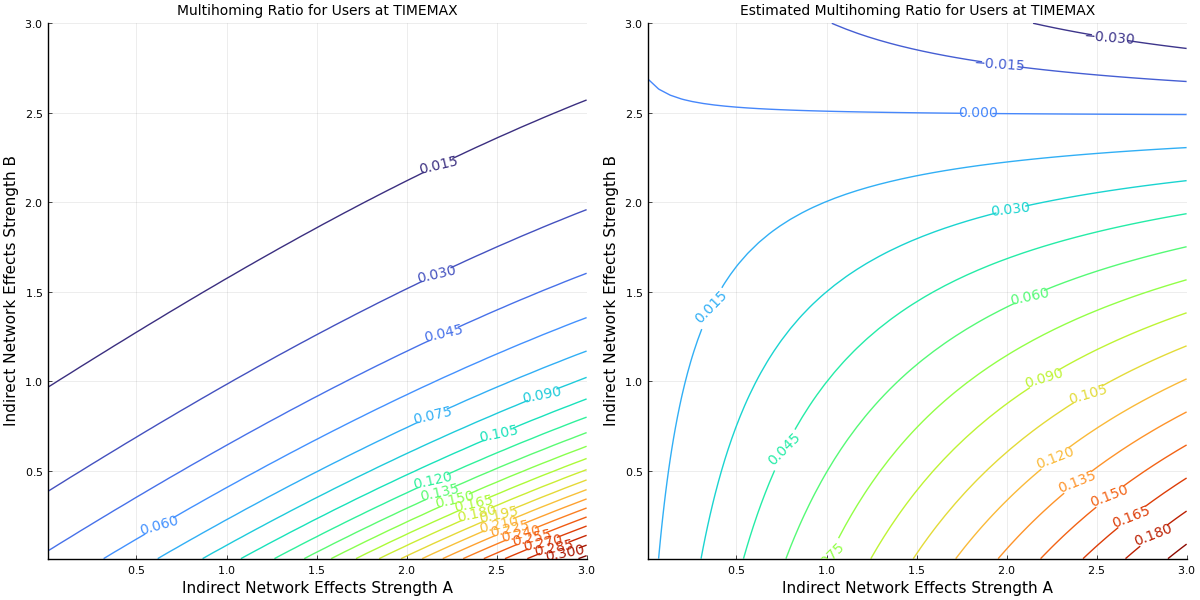

"d:\\Dropbox\\JuliaDocs\\1_DS_PSP_Case\\comparison_MHGratio_DSPSP.svg"

In [16]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Read the results from the CSV file
data = CSV.read("contourdspsp.csv", DataFrame)

# Define the values for the contour plot
xvals = data[:, :IndirectNetworkEffectsStrengthA]
yvals = data[:, :IndirectNetworkEffectsStrengthB]
zvals7 = data[:, :mhg_ratios_user_TMAX]

# Calculate model predictions for each row in the data
data[!, :model_predictions] = 0.01074284992775757 .+
                              0.06389172549619886 .* data[!, :IndirectNetworkEffectsStrengthA] .+
                              -0.003978313392518103 .* data[!, :IndirectNetworkEffectsStrengthB] .+
                              -0.025769082573659736 .* data[!, :IndirectNetworkEffectsStrengthA] .* data[!, :IndirectNetworkEffectsStrengthB]

# Define the grid for x and y
gridA = sort(unique(xvals))
gridB = sort(unique(yvals))

# Pivot the data so it matches the grid
pivot_df = unstack(data, :IndirectNetworkEffectsStrengthB, :IndirectNetworkEffectsStrengthA, :model_predictions)

# Get the predictions in matrix form
predictions_matrix = Matrix(pivot_df[:, 2:end])

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(gridA), length(gridB))
yvals_mtrx = reshape(yvals, length(gridA), length(gridB))
zvals7_mtrx = reshape(zvals7, length(gridA), length(gridB))

# Create a plot with 2 subplots
p1 = contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)

p2 = contour(gridA, gridB, predictions_matrix, 
             title="Estimated Multihoming Ratio for Users at TIMEMAX", 
             xlabel="Indirect Network Effects Strength A", 
             ylabel="Indirect Network Effects Strength B", 
             levels=21, color=:turbo, clabels=true, cbar=false, lw=1, 
             titlefontsize=10)

p = plot(p1, p2, layout = (1, 2), size = (1200, 600))

display(p)

# 画像ファイルとして保存
savefig(p, "comparison_MHGratio_DSPSP.png") 

savefig(p, "comparison_MHGratio_DSPSP.pdf") 

savefig(p, "comparison_MHGratio_DSPSP.svg") 

シミュレーションから得られたマルチホーミング率の等高線図と非線形回帰の推定式から得られる等高線図を出力する．(1)

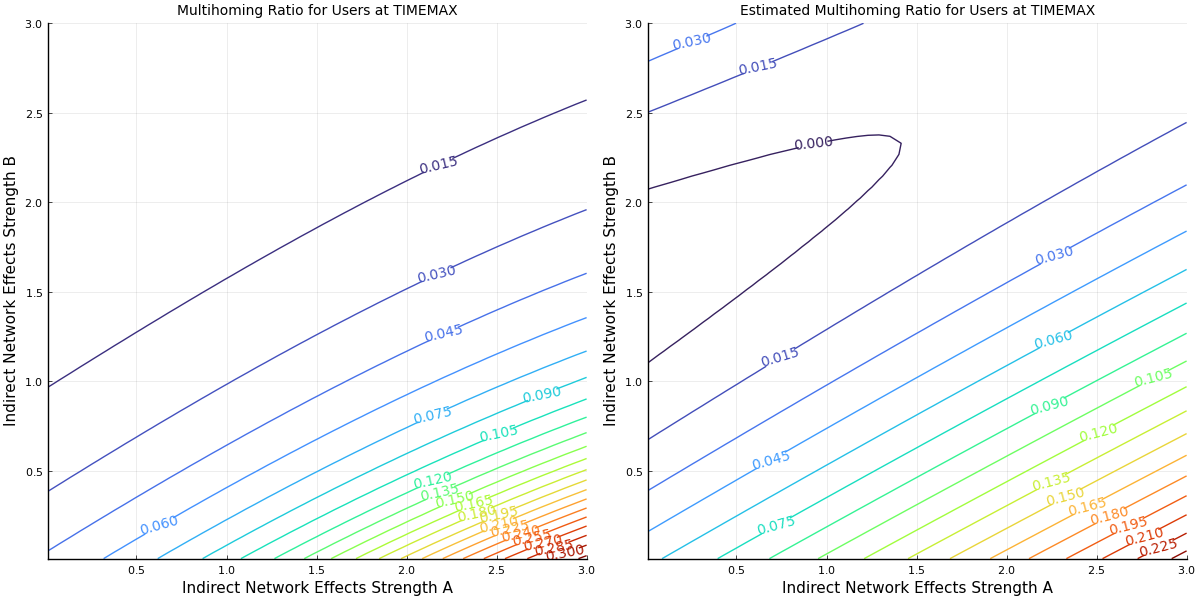

"d:\\Dropbox\\JuliaDocs\\1_DS_PSP_Case\\comparisonNL_MHGratio_DSPSP.svg"

In [17]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Read the results from the CSV file
data = CSV.read("contourdspsp.csv", DataFrame)

# Define the values for the contour plot
xvals = data[:, :IndirectNetworkEffectsStrengthA]
yvals = data[:, :IndirectNetworkEffectsStrengthB]
zvals7 = data[:, :mhg_ratios_user_TMAX]

# Calculate model predictions for each row in the data
data[!, :model_predictions] = 0.056763800764427746 .+
                              0.046028816431203476 .* data[!, :IndirectNetworkEffectsStrengthA] .+
                              -0.079108357406615 .* data[!, :IndirectNetworkEffectsStrengthB] .+
                              0.005934521286021551 .* data[!, :IndirectNetworkEffectsStrengthA].^2 .+
                              0.024960147515077684 .* data[!, :IndirectNetworkEffectsStrengthB].^2 .+
                              -0.025769082577080032 .* data[!, :IndirectNetworkEffectsStrengthA] .* data[!, :IndirectNetworkEffectsStrengthB]

# Define the grid for x and y
gridA = sort(unique(xvals))
gridB = sort(unique(yvals))

# Pivot the data so it matches the grid
pivot_df = unstack(data, :IndirectNetworkEffectsStrengthB, :IndirectNetworkEffectsStrengthA, :model_predictions)

# Get the predictions in matrix form
predictions_matrix = Matrix(pivot_df[:, 2:end])

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(gridA), length(gridB))
yvals_mtrx = reshape(yvals, length(gridA), length(gridB))
zvals7_mtrx = reshape(zvals7, length(gridA), length(gridB))

# Create a plot with 2 subplots
p1 = contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)

p2 = contour(gridA, gridB, predictions_matrix, 
             title="Estimated Multihoming Ratio for Users at TIMEMAX", 
             xlabel="Indirect Network Effects Strength A", 
             ylabel="Indirect Network Effects Strength B", 
             levels=21, color=:turbo, clabels=true, cbar=false, lw=1, 
             titlefontsize=10)

p = plot(p1, p2, layout = (1, 2), size = (1200, 600))

display(p)

# 画像ファイルとして保存
savefig(p, "comparisonNL_MHGratio_DSPSP.png") 

savefig(p, "comparisonNL_MHGratio_DSPSP.pdf") 

savefig(p, "comparisonNL_MHGratio_DSPSP.svg") 

シミュレーションから得られたマルチホーミング率の等高線図と非線形回帰の推定式から得られる総天然色等高線図を出力する．

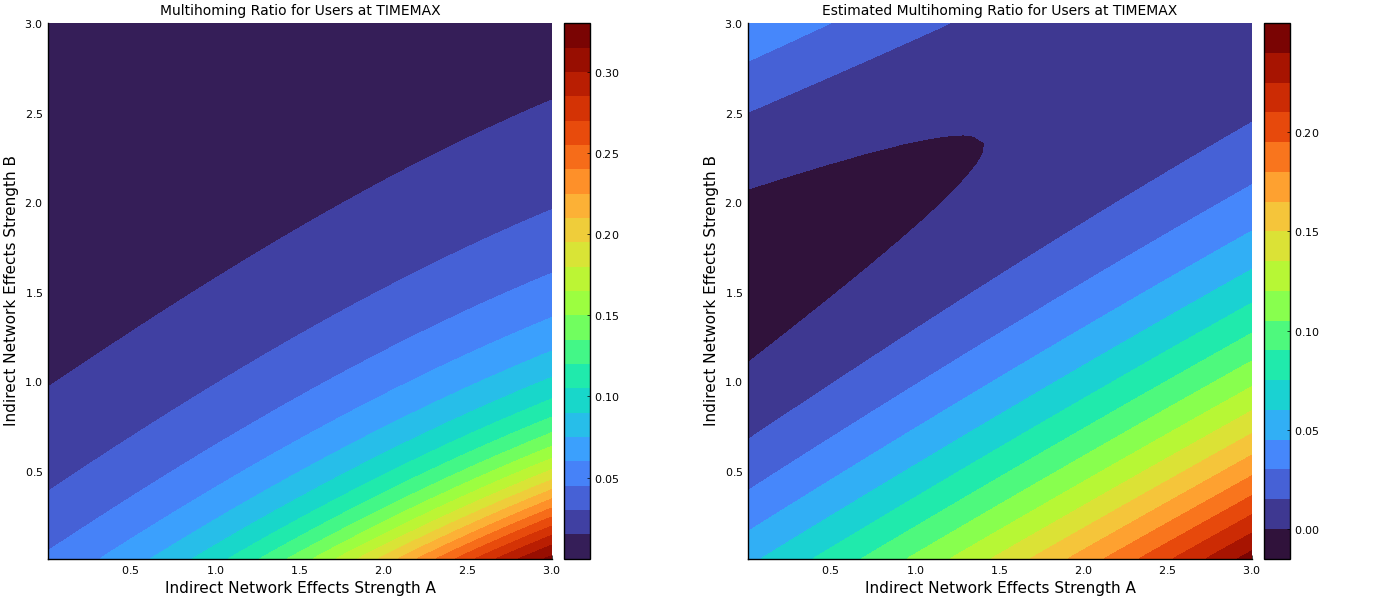

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"d:\\Dropbox\\JuliaDocs\\1_DS_PSP_Case\\comparisonNLfull_MHGratio_DSPSP.svg"

In [18]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Read the results from the CSV file
data = CSV.read("contourdspsp.csv", DataFrame)

# Define the values for the contour plot
xvals = data[:, :IndirectNetworkEffectsStrengthA]
yvals = data[:, :IndirectNetworkEffectsStrengthB]
zvals7 = data[:, :mhg_ratios_user_TMAX]

# Calculate model predictions for each row in the data
data[!, :model_predictions] = 0.056763800764427746 .+
                              0.046028816431203476 .* data[!, :IndirectNetworkEffectsStrengthA] .+
                              -0.079108357406615 .* data[!, :IndirectNetworkEffectsStrengthB] .+
                              0.005934521286021551 .* data[!, :IndirectNetworkEffectsStrengthA].^2 .+
                              0.024960147515077684 .* data[!, :IndirectNetworkEffectsStrengthB].^2 .+
                              -0.025769082577080032 .* data[!, :IndirectNetworkEffectsStrengthA] .* data[!, :IndirectNetworkEffectsStrengthB]

# Define the grid for x and y
gridA = sort(unique(xvals))
gridB = sort(unique(yvals))

# Pivot the data so it matches the grid
pivot_df = unstack(data, :IndirectNetworkEffectsStrengthB, :IndirectNetworkEffectsStrengthA, :model_predictions)

# Get the predictions in matrix form
predictions_matrix = Matrix(pivot_df[:, 2:end])

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(gridA), length(gridB))
yvals_mtrx = reshape(yvals, length(gridA), length(gridB))
zvals7_mtrx = reshape(zvals7, length(gridA), length(gridB))

# Create a plot with 2 subplots
p1 = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)

p2 = contourf(gridA, gridB, predictions_matrix, 
             title="Estimated Multihoming Ratio for Users at TIMEMAX", 
             xlabel="Indirect Network Effects Strength A", 
             ylabel="Indirect Network Effects Strength B", 
             levels=21, color=:turbo, 
             titlefontsize=10)

p = plot(p1, p2, layout = (1, 2), size = (1400, 600))

display(p)

# 画像ファイルとして保存
savefig(p, "comparisonNLfull_MHGratio_DSPSP.png") 

savefig(p, "comparisonNLfull_MHGratio_DSPSP.pdf") 

savefig(p, "comparisonNLfull_MHGratio_DSPSP.svg") 

非線形回帰モデルの値（マルチホーミング率）が負値の場合は、強制的に0に変換する。シミュレーションから得られたマルチホーミング率の等高線図と上記の非線形回帰の推定式から得られる総天然色等高線図を出力する．等高線図のデータから誤差を計算し、表出力する。

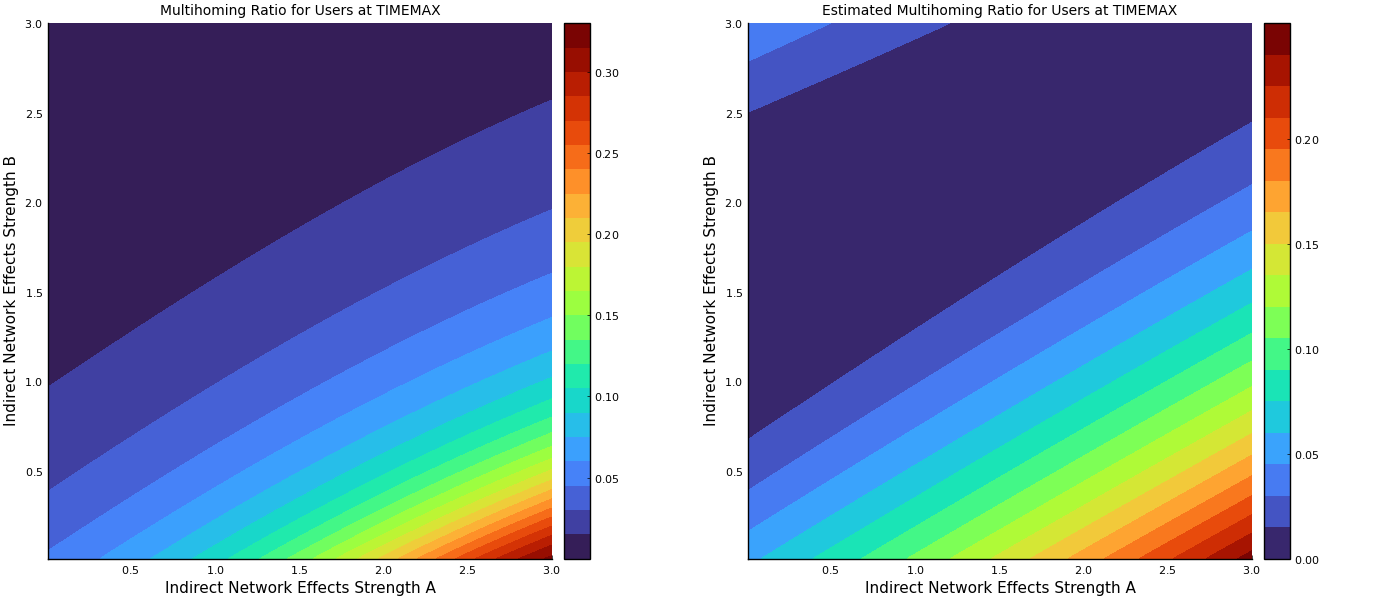

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"d:\\Dropbox\\JuliaDocs\\1_DS_PSP_Case\\comparisonNLfull_DSPSP.pdf"

In [19]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Read the results from the CSV file
data = CSV.read("contourdspsp.csv", DataFrame)

# Define the values for the contour plot
xvals = data[:, :IndirectNetworkEffectsStrengthA]
yvals = data[:, :IndirectNetworkEffectsStrengthB]
zvals7 = data[:, :mhg_ratios_user_TMAX]

# Calculate model predictions for each row in the data
data[!, :model_predictions] = 0.056763800764427746 .+
                              0.046028816431203476 .* data[!, :IndirectNetworkEffectsStrengthA] .+
                              -0.079108357406615 .* data[!, :IndirectNetworkEffectsStrengthB] .+
                              0.005934521286021551 .* data[!, :IndirectNetworkEffectsStrengthA].^2 .+
                              0.024960147515077684 .* data[!, :IndirectNetworkEffectsStrengthB].^2 .+
                              -0.025769082577080032 .* data[!, :IndirectNetworkEffectsStrengthA] .* data[!, :IndirectNetworkEffectsStrengthB]

# If the model prediction is negative, set it to 0
data[!, :model_predictions] = max.(0.0, data[!, :model_predictions])

# Define the grid for x and y
gridA = sort(unique(xvals))
gridB = sort(unique(yvals))

# Pivot the data so it matches the grid
pivot_df = unstack(data, :IndirectNetworkEffectsStrengthB, :IndirectNetworkEffectsStrengthA, :model_predictions)

# Get the predictions in matrix form
predictions_matrix = Matrix(pivot_df[:, 2:end])

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(gridA), length(gridB))
yvals_mtrx = reshape(yvals, length(gridA), length(gridB))
zvals7_mtrx = reshape(zvals7, length(gridA), length(gridB))

# Create a plot with 2 subplots
p1 = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=21, color=:turbo, titlefontsize=10)

p2 = contourf(gridA, gridB, predictions_matrix, 
             title="Estimated Multihoming Ratio for Users at TIMEMAX", 
             xlabel="Indirect Network Effects Strength A", 
             ylabel="Indirect Network Effects Strength B", 
             levels=21, color=:turbo, 
             titlefontsize=10)

p = plot(p1, p2, layout = (1, 2), size = (1400, 600))

display(p)

# 画像ファイルとして保存
savefig(p, "comparisonNLfull_DSPSP.png") 

savefig(p, "comparisonNLfull_DSPSP.pdf") 
